In [12]:
import pandas as pd
import numpy as np

In [64]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')[['product_name', 'product_category_tree', 'image', 'description']]

In [14]:
df.head()

,product_name,product_category_tree,image,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...


## TRAITEMENT DE LA VARIABLE CIBLE : Categorie_Produit

In [65]:
def get_category(chaine):
    ch = chaine[2:]
    j=0
    for i in ch:
        if i != '>':
            j+=1
        else:
            break

    return ch[:j-1]

In [66]:
df.product_category_tree = df.product_category_tree.apply(get_category)

In [67]:
df.product_category_tree.value_counts()

Home Decor & Festive Needs    150
Beauty and Personal Care      150
Kitchen & Dining              150
Baby Care                     150
Watches                       150
Computers                     150
Home Furnishing               150
Name: product_category_tree, dtype: int64

# PREPROCESSING DES IMAGES

## FONCTIONS DE TRAITEMENT DES IMAGES

In [68]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt



def img_np_array(img_filename):
    ######################################
    # READ IMAGE FROM FILE
    ######################################
    #load file as pillow Image 
    img = Image.open('images/'+img_filename)

    # convert to grayscale
    imgray = img.convert(mode='L')

    #convert to NumPy array
    img_array = np.asarray(imgray)
    
    return img_array

############## version condensée#################
def img_np_array_ver_cond(img_filename):
    return np.asarray(Image.open('images/'+img_filename).convert(mode='L'))


####################################################################################
def egaliser_histogramme_image(img_filename):
    ######################################
    # READ IMAGE FROM FILE
    ######################################
    #load file as pillow Image 
    img = Image.open(img_filename)

    # convert to grayscale
    imgray = img.convert(mode='L')

    #convert to NumPy array
    img_array = np.asarray(imgray)
    
    ######################################
    # PERFORM HISTOGRAM EQUALIZATION
    ######################################

    """
    STEP 1: Normalized cumulative histogram
    """
    #flatten image array and calculate histogram via binning
    histogram_array = np.bincount(img_array.flatten(), minlength=256)

    #normalize
    num_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/num_pixels

    #normalized cumulative histogram
    chistogram_array = np.cumsum(histogram_array)


    """
    STEP 2: Pixel mapping lookup table
    """
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8)


    """
    STEP 3: Transformation
    """
    # flatten image array into 1D list
    img_list = list(img_array.flatten())

    # transform pixel values to equalize
    eq_img_list = [transform_map[p] for p in img_list]

    # reshape and write back into img_array
    eq_img_array = np.reshape(np.asarray(eq_img_list), img_array.shape)
    
    ######################################
    # WRITE EQUALIZED IMAGE TO FILE
    ######################################
    #convert NumPy array to pillow Image and write to file
    eq_img = Image.fromarray(eq_img_array, mode='L')
    #eq_img.save(save_filename)
    return eq_img

#---------------------------------------
def egaliser_hist_img_Opencv(image):
    return cv2.equalizeHist(image)


####################################################################################
def filtrage_bruit_img(img):
    # Créer l'image à partir de tableau numpy
    img = Image.fromarray(img).convert('L')
    # Appliquer le lissage par moyennag
    img = img.filter(ImageFilter.BoxBlur(1))
    
    return img


####################################################################################
def filtrage_bruit_img_vers_cond(img):
    # Créer l'image à partir d'un tableau numpy avec "Image.fromarray"
    # Appliquer le lissage par moyennag "ImageFilter.BoxBlur(1)"
    return Image.fromarray(img).convert('L').filter(ImageFilter.BoxBlur(1))


## Création du dataset des images en tb_np

In [26]:
img_np_array_ver_cond(df.image[0]).shape

(3600, 3600)

In [27]:
df.image = df.image.apply(img_np_array_ver_cond)

C:\Users\Zakaria\anaconda3\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [39]:
df.image[0].shape

(3600, 3600)

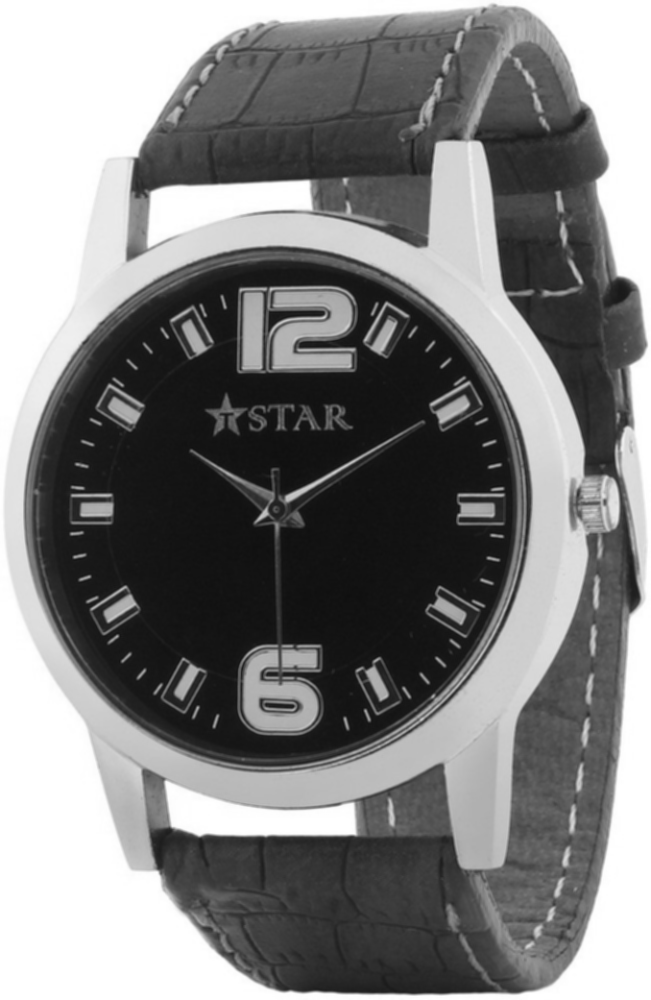

In [33]:
filtrage_bruit_img_vers_cond(df.image[7])

### Détermination et affichage des descripteurs SIFT d'une image comme exemple

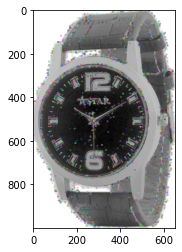

Descripteurs :  (2139, 128)

[[ 28.   0.   0. ...   0.   0.   0.]
 [ 75.  33.   0. ...   0.   0.   1.]
 [ 17.   0.   0. ...   0.   0.   0.]
 ...
 [ 98. 151.   3. ...   0.   0.   0.]
 [135.  14.   0. ...   8.   0.   0.]
 [ 91.  27.   0. ...   0.  13.  30.]]


In [30]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()

# equalize image histogram
image = egaliser_hist_img_Opencv(df.image[7])

# récupération des points clé et des descripteurs
kp, des = sift.detectAndCompute(image, None)

# dessiner les points clés sur l'image
img=cv2.drawKeypoints(image,kp,image)

plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


## Pré-traitement des images via SIFT

### Créations des descripteurs de chaque image
* Pour chaque image, filtrage du bruit (s'il y'en a) et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [41]:
# identification of key points and associated descriptors
# identificaation des points clés ainsi que les descripteurs associés
import time, cv2


sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

# par défaut de memoire,
#j'ai été obligé d'utiliser que 350 premières images, 
#soit les un tier (1/3)

for image in df.image[:df.shape[0]//3] :
    # filtrage du bruit
    image = np.array(filtrage_bruit_img_vers_cond(image))
    
    # equalize image histogram
    res = egaliser_hist_img_Opencv(image)
    
    # récupération des points clé et des descripteurs
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)


sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


C:\Users\Zakaria\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Nombre de descripteurs :  (171611, 128)
temps de traitement SIFT descriptor :           509.83 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [42]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  414
Création de 414 clusters de descripteurs ...
temps de traitement kmeans :             4.72 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
   

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [43]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
     #calculates the histogram
    hist = build_histogram(kmeans, image_desc, i) 
    
    #histogram is the feature vector
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


temps de création histogrammes :             1.71 secondes


# Réductions de dimension

## Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [45]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (350, 414)
Dimensions dataset après réduction PCA :  (350, 155)


## Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [69]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df.product_category_tree
print(df_tsne.shape)


(350, 3)


# Analyse visuelle : affichage T-SNE selon catégories d'images

In [70]:
import seaborn as sns

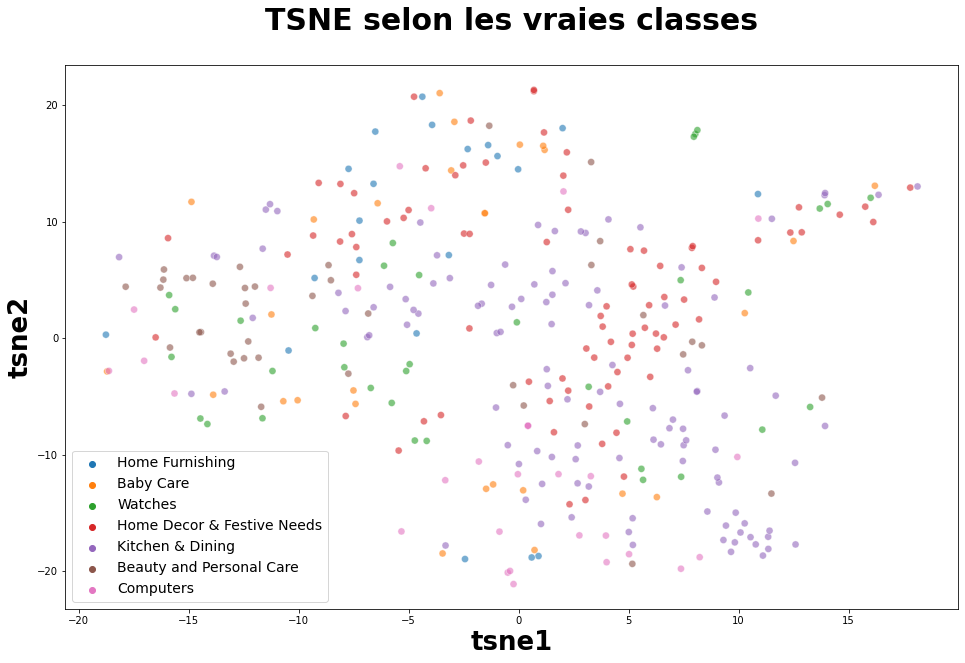

In [72]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


# Analyse mesures : similarité entre catégories et clusters

##  Création de clusters à partir du T-SNE

In [74]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(350, 4)
(350, 4)


In [56]:
cls.labels_.shape

(350,)

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.08321619984156517 reste faible

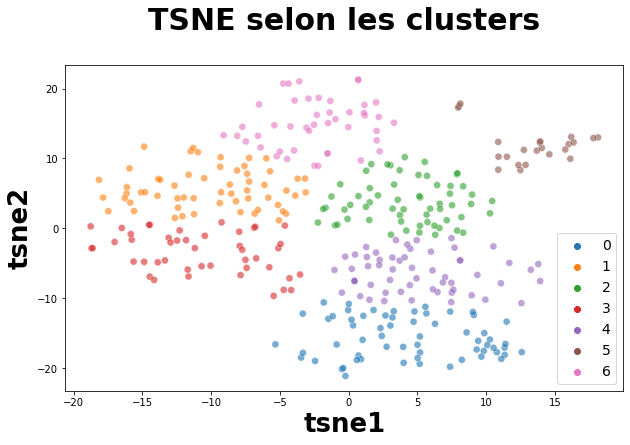

ARI :  0.08321619984156517


In [75]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df.product_category_tree
print("ARI : ", metrics.adjusted_rand_score(labels[:350], cls.labels_))